# Analiza robusnosti klasičnih metoda segmentacije na šum i varijacije kontrasta

### Projekt iz kolegija: Računalni vid  
### Autor: Antonio Jerković
### Fakultet: Sveučilište u Slavonskom Brodu
### Ak. godina: 2026

## 1. Uvod

Ovaj notebook predstavlja eksperimentalni dio seminarskog rada iz kolegija *Računalni vid*.  
Cilj je analizirati utjecaj Gaussian šuma i promjena kontrasta na klasični segmentacijski pipeline, koji se sastoji od filtriranja, binarizacije i morfoloških operacija.  

U realnim uvjetima slike su često degradirane šumom, promjenama kontrasta i osvjetljenja. Takve degradacije mogu značajno utjecati na kvalitetu segmentacije, osobito kod klasičnih metoda koje se oslanjaju na jednostavne pragove i filtere.  

U ovom notebooku demonstracija se radi na jednoj slici iz GlaS (Gland Segmentation) dataseta, ali se postupak može proširiti na cijeli skup podataka.  
Analiziraju se sljedeće degradacije:
- Gaussian šum
- niski kontrast
- visoki kontrast

Evaluacija se provodi pomoću metrika Dice i IoU, uz vizualnu usporedbu rezultata.

## 2. Pregled područja i problematike (state of the art)

Klasične metode obrade slike i segmentacije uključuju nekoliko ključnih koraka:

### 2.1. Filtriranje

Filtriranje se koristi za smanjenje šuma i zaglađivanje slike:
- Gaussian blur: niskopropusni filter koji zaglađuje sliku uz pretpostavku Gaussian šuma.
- Median filter: posebno učinkovit za impulsni (salt & pepper) šum.
- Bilateral filter: čuva rubove dok zaglađuje unutrašnjost područja (nije nužno, ali je relevantan kao napredniji pristup).

### 2.2. Binarizacija

Binarizacija pretvara sivu sliku u binarnu (0/255) na temelju praga:
- Globalni prag: isti prag za cijelu sliku.
- Otsu metoda: automatski pronalazi optimalan globalni prag na temelju histograma slike.
- Adaptivni thresholding: prag se računa lokalno u manjim prozorima, što je korisno kod neujednačenog osvjetljenja.

### 2.3. Morfološke operacije

Morfološke operacije rade nad binarnim slikama:
- Erozija: smanjuje bijela područja, uklanja male objekte.
- Dilatacija: proširuje bijela područja, popunjava rupe.
- Opening (erozija pa dilatacija): uklanja male objekte, čisti šum.
- Closing (dilatacija pa erozija): popunjava male rupe u objektima.

### 2.4. Utjecaj šuma i kontrasta

Prema literaturi, šum i promjene kontrasta imaju sljedeće efekte:
- Šum otežava određivanje praga jer histogram postaje "razmazan".
- Niski kontrast smanjuje razliku između objekta i pozadine, što otežava segmentaciju.
- Visoki kontrast može poboljšati segmentaciju, ali istovremeno naglasiti šum.
- Klasične metode su osjetljive na degradacije jer nemaju sposobnost učenja robusnih značajki kao moderne deep learning metode.

U ovom radu fokus je na kvantitativnoj i vizualnoj analizi robusnosti klasičnog segmentacijskog pipelinea na degradacije slike.

### Uvoz biblioteka

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

plt.rcParams['figure.figsize'] = (6,4)

## 3. Dataset i učitavanje podataka

U radu se koristi GlaS (Gland Segmentation) dataset, koji sadrži histološke slike žlijezda i pripadajuće ground truth maske.

U ovom notebooku demonstracija se radi na jednoj slici i pripadajućoj maski, ali se isti postupak može proširiti na cijeli dataset.

Slike se nalaze u folderu **slike/**:
- slika: `testA_1.bmp`
- maska: `testA_1_anno.bmp`

### Učitavanje slike

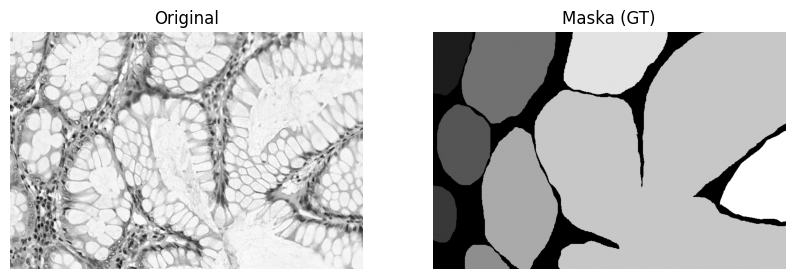

In [ ]:
img = cv2.imread("slike/testA_1.bmp", cv2.IMREAD_GRAYSCALE)
mask = cv2.imread("slike/testA_1_anno.bmp", cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(img, cmap='gray'); plt.title("Original"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(mask, cmap='gray'); plt.title("Maska (GT)"); plt.axis('off')
plt.show()

## 4. Degradacije slike

U ovom dijelu umjetno degradiramo sliku kako bismo analizirali robusnost segmentacijskog pipelinea na:

- Gaussian šum
- niski kontrast
- visoki kontrast

### Funkcije za degradacije

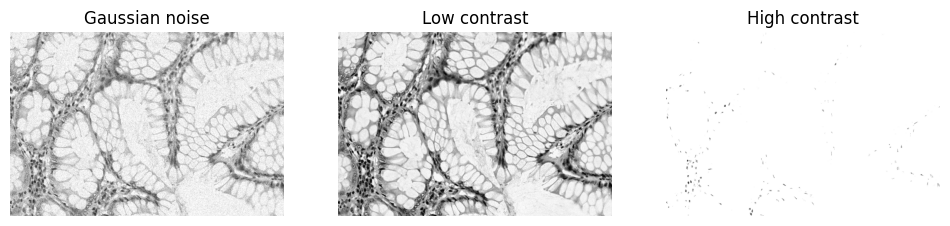

In [ ]:
def add_gaussian_noise(image, mean=0, sigma=40):
    noise = np.random.normal(mean, sigma, image.shape).astype(np.float32)
    noisy = image.astype(np.float32) + noise
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)
    return noisy

def change_contrast(image, alpha=1.5, beta=0):
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

noisy = add_gaussian_noise(img, sigma=20)
low_contrast = change_contrast(img, alpha=0.4, beta=-30)
high_contrast = change_contrast(img, alpha=2.5, beta=30)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(noisy, cmap='gray'); plt.title("Gaussian noise"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(low_contrast, cmap='gray'); plt.title("Low contrast"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(high_contrast, cmap='gray'); plt.title("High contrast"); plt.axis('off')
plt.show()

## 5. Klasični segmentacijski pipeline

Segmentacijski pipeline sastoji se od sljedećih koraka:

1. Filtriranje (Gaussian blur)
2. Binarizacija (Otsu metoda)
3. Morfološke operacije (opening, closing)

Isti pipeline primjenjuje se na:
- originalnu sliku
- sliku s Gaussian šumom
- sliku s niskim kontrastom
- sliku s visokim kontrastom

### Funkcije za segmentaciju

In [ ]:
kernel = np.ones((3,3), np.uint8)

def segment_pipeline(image):
    blur = cv2.GaussianBlur(image, (5,5), 0)
    _, otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    opened = cv2.morphologyEx(otsu, cv2.MORPH_OPEN, kernel)
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)
    return closed

### Primjena pipelinea na sve verzije slike

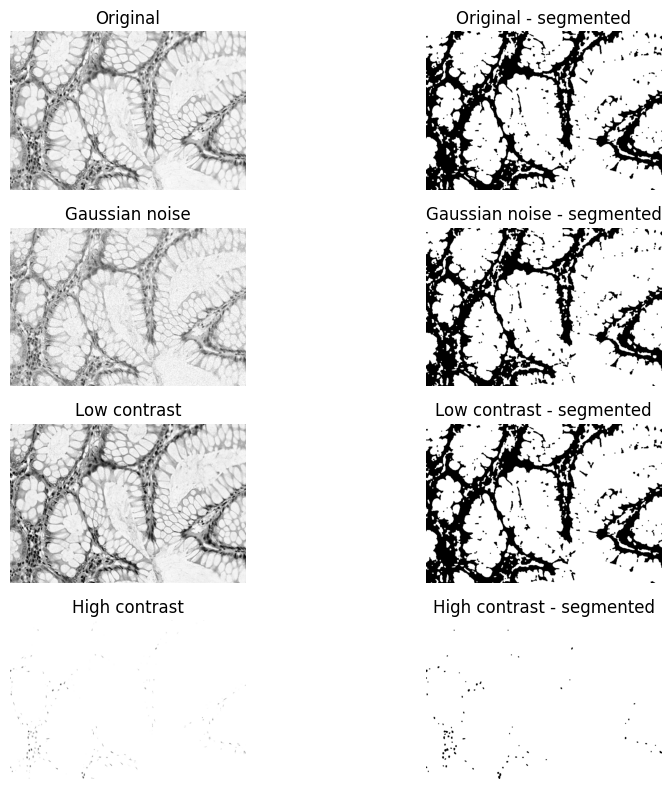

In [ ]:
images = {
    "Original": img,
    "Gaussian noise": noisy,
    "Low contrast": low_contrast,
    "High contrast": high_contrast
}

segmented = {}

plt.figure(figsize=(10,8))
for i, (name, im) in enumerate(images.items(), 1):
    seg = segment_pipeline(im)
    segmented[name] = seg
    plt.subplot(4,2,2*i-1); plt.imshow(im, cmap='gray'); plt.title(name); plt.axis('off')
    plt.subplot(4,2,2*i); plt.imshow(seg, cmap='gray'); plt.title(f"{name} - segmented"); plt.axis('off')

plt.tight_layout()
plt.show()

## 6. Evaluacija robusnosti

Za kvantitativnu evaluaciju koriste se:

- Dice koeficijent
- IoU (Intersection over Union)

Metrike se računaju između dobivene segmentacije i ground truth maske za:
- originalnu sliku
- sliku s Gaussian šumom
- sliku s niskim kontrastom
- sliku s visokim kontrastom

### Definicija metrika

In [ ]:
def dice_score(pred, gt):
    pred = pred > 0
    gt = gt > 0
    intersection = np.logical_and(pred, gt).sum()
    denom = pred.sum() + gt.sum()
    return 2 * intersection / denom if denom != 0 else 1.0

def iou_score(pred, gt):
    pred = pred > 0
    gt = gt > 0
    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    return intersection / union if union != 0 else 1.0

### Izračun metrika i tablica rezultata

In [ ]:
results = []

for name, seg in segmented.items():
    d = dice_score(seg, mask)
    j = iou_score(seg, mask)
    results.append({"Slika": name, "Dice": d, "IoU": j})

df_results = pd.DataFrame(results)
df_results

,Slika,Dice,IoU
0,Original,0.846646,0.734073
1,Gaussian noise,0.852792,0.743362
2,Low contrast,0.846033,0.733152
3,High contrast,0.925074,0.860594


### Grafički prikaz metrika

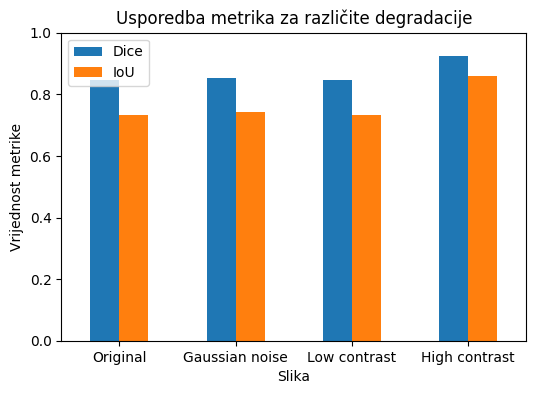

In [ ]:
ax = df_results.plot(x="Slika", y=["Dice", "IoU"], kind="bar", ylim=(0,1), rot=0)
ax.set_title("Usporedba metrika za različite degradacije")
ax.set_ylabel("Vrijednost metrike")
plt.show()

## 7. Analiza dobivenih rezultata

Na temelju dobivenih metrika (Dice i IoU) i vizualnih rezultata može se uočiti:

- **Originalna slika**: očekivano daje najbolje rezultate jer nema degradacija.
- **Gaussian šum**: smanjuje kvalitetu segmentacije, osobito ako je šum jači. Histogram slike postaje razmazan, što otežava određivanje optimalnog praga.
- **Niski kontrast**: razlika između objekta i pozadine je manja, pa Otsu metoda teže pronalazi dobar prag. Rezultat je često podsegmentacija ili nadsegmentacija.
- **Visoki kontrast**: može poboljšati razliku između objekta i pozadine, ali istovremeno naglasiti šum i artefakte.

Morfološke operacije (opening i closing) donekle popravljaju rezultate uklanjanjem malih objekata i popunjavanjem rupa, ali ne mogu u potpunosti kompenzirati lošu binarizaciju uzrokovanu jakim šumom ili vrlo niskim kontrastom.

## 8. Zaključak

U ovom radu analizirana je robusnost klasičnog segmentacijskog pipelinea (filtriranje, binarizacija, morfologija) na degradacije slike u vidu Gaussian šuma i promjena kontrasta.

Glavni zaključci su:

- Klasične metode segmentacije osjetljive su na šum i varijacije kontrasta.
- Gaussian šum značajno degradira performanse binarizacije, osobito pri višim razinama šuma.
- Niski kontrast otežava razdvajanje objekta i pozadine, što dovodi do lošijih metrika (Dice, IoU).
- Visoki kontrast može poboljšati segmentaciju, ali uz rizik naglašavanja šuma.
- Morfološke operacije mogu djelomično popraviti rezultate, ali ne rješavaju temeljni problem degradirane slike.

U realnim primjenama preporučuje se:
- korištenje naprednijih metoda filtriranja (npr. bilateral filter, NL-means),
- prilagodba kontrasta (npr. CLAHE),
- ili primjena modernih metoda temeljenih na dubokim neuronskim mrežama, koje su robusnije na degradacije slike.

## 9. Literatura

Detaljna literatura navedena je u pisanom dijelu rada.

## 10. Popis programa i upute za korištenje

Sav programski kod nalazi se u ovom Google Colab notebooku i može se prenijeti na GitHub kao `.ipynb` datoteka.

### 10.1. Ovisnosti

Projekt koristi sljedeće biblioteke:

- Python 3  
- OpenCV (`cv2`)  
- NumPy  
- Matplotlib  
- Pandas  
- Google Colab okruženje  

Sve navedene biblioteke dostupne su u standardnom Google Colab okruženju i nije potrebna dodatna instalacija.

### 10.2. Način korištenja

1. Otvoriti Google Colab i učitati `.ipynb` datoteku.  
2. Pokrenuti sve ćelije redom od vrha prema dnu.  
3. Slike i pripadajuće maske moraju se nalaziti u folderu **`slike/`** unutar Colab radnog direktorija.  
   - Primjer strukture:
     - `slike/testA_1.bmp`  
     - `slike/testA_1_anno.bmp`  
4. Notebook automatski učitava sliku i masku te provodi:
   - degradacije slike (Gaussian šum, niski i visoki kontrast)  
   - segmentaciju klasičnim pipelineom  
   - evaluaciju (Dice, IoU)  
5. Rezultati se prikazuju u obliku:
   - vizualnih prikaza (slike prije/poslije)  
   - tablice metrika  
   - grafičke usporedbe  
6. Notebook se može spremiti kao `.ipynb` i postaviti na GitHub, a rezultati (slike, tablice, grafovi) mogu se koristiti u PDF izvještaju i prezentaciji.